# Observational trigger optimization

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
import math

import numpy as np
import pandas as pd
import ocha_stratus as stratus
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter
from tqdm.auto import tqdm

from src.datasources import ibtracs
from src.constants import *

In [3]:
df_storms = ibtracs.load_storms()

In [4]:
df_storms["name_season"] = (
    df_storms["name"].str.capitalize() + " " + df_storms["season"].astype(str)
)

In [5]:
blob_name = (
    f"{PROJECT_PREFIX}/processed/storm_stats/zma_stats_imerg_quantiles.parquet"
)

df_stats_raw = stratus.load_parquet_from_blob(blob_name)

In [6]:
blob_name = f"{PROJECT_PREFIX}/processed/impact/emdat_cerf_upto2024.parquet"
df_impact = stratus.load_parquet_from_blob(blob_name)
df_impact["cerf"] = ~df_impact["Amount in US$"].isnull()

In [7]:
cols = [
    "sid",
    "cerf",
    "Total Affected",
    "Total Deaths",
    "Total Damage, Adjusted ('000 US$)",
    "Amount in US$",
]
df_impact = df_impact[cols]

In [8]:
df_impact[df_impact["cerf"]]

,sid,cerf,Total Affected,Total Deaths,"Total Damage, Adjusted ('000 US$)",Amount in US$
11,2008238N13293,True,450019.0,NaN,2816413.0,2487431.0
12,2008245N17323,True,NaN,7.0,2038909.0,4880085.0
15,2012296N14283,True,162605.0,11.0,NaN,5522753.0
16,2016273N13300,True,190000.0,NaN,3170332.0,5352736.0
17,2017242N16333,True,10000000.0,10.0,644720.0,7999469.0
24,2022266N12294,True,3200000.0,3.0,25000.0,7827734.0
27,2024293N21294,True,320000.0,10.0,NaN,3499569.0
28,2024309N13283,True,4000000.0,NaN,NaN,5999888.0


In [9]:
df_impact["Amount in US$"].mean()

np.float64(5446208.125)

In [10]:
df_impact["Amount in US$"].sum()

np.float64(43569665.0)

In [11]:
df_impact["Amount in US$"].sum() / (2024 - 2000 + 1)

np.float64(1742786.6)

In [12]:
df_stats = df_stats_raw.merge(df_impact, how="left").merge(
    df_storms[["sid", "season", "name", "name_season"]], how="left"
)


def set_cerf(row):
    if row["season"] < 2006:
        return np.nan
    else:
        if row["cerf"] == True:
            return True
        else:
            return False


df_stats["cerf"] = df_stats.apply(set_cerf, axis=1)
df_stats["cerf_str"] = df_stats["cerf"].astype(str)
emdat_cols = [
    "Total Affected",
    "Total Deaths",
    "Total Damage, Adjusted ('000 US$)",
]
for col in emdat_cols:
    df_stats[col] = df_stats[col].fillna(0).astype(int)
df_stats

,sid,valid_time_min,valid_time_max,wind_speed_max,wind_speed_max_landfall,q50_total,q50_total_mean_abv,q50_roll2,q50_roll2_mean_abv,q50_roll3,...,q99_roll3_mean_abv,cerf,Total Affected,Total Deaths,"Total Damage, Adjusted ('000 US$)",Amount in US$,season,name,name_season,cerf_str
0,2000233N12316,2000-08-24 00:00:00.000040,2000-08-24 12:00:00.000040,40.0,NaN,18.190000,35.262634,18.152500,34.911701,18.189999,...,70.882492,NaN,0,0,0,NaN,2000,DEBBY,Debby 2000,nan
1,2000260N15308,2000-09-19 12:00:00.000040,2000-09-20 18:00:00.000040,30.0,NaN,26.412498,68.799995,21.250000,62.718685,23.750000,...,184.656494,NaN,0,0,0,NaN,2000,HELENE,Helene 2000,nan
2,2001303N13276,2001-11-04 06:00:00.000040,2001-11-05 06:00:00.000040,120.0,115.0,94.369999,214.020828,76.807495,195.712280,94.297501,...,404.398499,NaN,5900012,5,165279,NaN,2001,MICHELLE,Michelle 2001,nan
3,2002258N10300,2002-09-19 18:00:00.000040,2002-09-21 18:00:00.000040,110.0,75.0,78.592495,207.540146,40.644997,143.821213,56.139999,...,794.184509,NaN,42500,0,37421,NaN,2002,ISIDORE,Isidore 2002,nan
4,2002265N10315,2002-09-29 00:00:00.000040,2002-10-02 00:00:00.000040,90.0,90.0,54.195000,89.869759,37.119995,67.565186,43.507500,...,183.679001,NaN,281470,3,37421,NaN,2002,LILI,Lili 2002,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,2023321N15278,2023-11-18 00:00:00.000039,2023-11-18 00:00:00.000039,30.0,NaN,3.947500,38.300976,3.947500,38.281227,3.947500,...,161.707001,False,0,0,0,NaN,2023,UNNAMED,Unnamed 2023,False
58,2024216N20284,2024-08-02 12:00:00.000039,2024-08-04 00:00:00.000039,35.0,30.0,54.164997,103.377747,40.412502,75.217384,49.295002,...,240.353485,False,0,0,0,NaN,2024,DEBBY,Debby 2024,False
59,2024268N17278,2024-09-25 12:00:00.000039,2024-09-25 12:00:00.000039,65.0,NaN,25.417499,116.488297,21.440001,99.156189,25.417500,...,307.214508,False,0,0,0,NaN,2024,HELENE,Helene 2024,False
60,2024293N21294,2024-10-20 06:00:00.000039,2024-10-22 06:00:00.000039,75.0,75.0,12.205000,61.957958,9.135000,50.185165,12.029999,...,533.183960,True,320000,10,0,3499569.0,2024,OSCAR,Oscar 2024,True


In [13]:
target_rp = 4
total_years = 2024 - 2000 + 1
target_year_count = math.floor((total_years + 1) / target_rp)

In [14]:
target_year_count

6

In [15]:
total_affected_thresh = None
for total_affected in sorted(df_stats["Total Affected"], reverse=True):
    dff = df_stats[df_stats["Total Affected"] >= total_affected]
    display(dff)
    print(total_affected)
    if dff["season"].nunique() <= target_year_count:
        total_affected_thresh = total_affected
    else:
        break

,sid,valid_time_min,valid_time_max,wind_speed_max,wind_speed_max_landfall,q50_total,q50_total_mean_abv,q50_roll2,q50_roll2_mean_abv,q50_roll3,...,q99_roll3_mean_abv,cerf,Total Affected,Total Deaths,"Total Damage, Adjusted ('000 US$)",Amount in US$,season,name,name_season,cerf_str
39,2017242N16333,2017-09-08 12:00:00.000039,2017-09-10 06:00:00.000039,145.0,130.0,108.57999,170.772461,86.267494,140.139038,100.352501,...,298.256531,True,10000000,10,644720,7999469.0,2017,IRMA,Irma 2017,True


10000000


,sid,valid_time_min,valid_time_max,wind_speed_max,wind_speed_max_landfall,q50_total,q50_total_mean_abv,q50_roll2,q50_roll2_mean_abv,q50_roll3,...,q99_roll3_mean_abv,cerf,Total Affected,Total Deaths,"Total Damage, Adjusted ('000 US$)",Amount in US$,season,name,name_season,cerf_str
2,2001303N13276,2001-11-04 06:00:00.000040,2001-11-05 06:00:00.000040,120.0,115.0,94.369999,214.020828,76.807495,195.712280,94.297501,...,404.398499,NaN,5900012,5,165279,NaN,2001,MICHELLE,Michelle 2001,nan
39,2017242N16333,2017-09-08 12:00:00.000039,2017-09-10 06:00:00.000039,145.0,130.0,108.579990,170.772461,86.267494,140.139038,100.352501,...,298.256531,True,10000000,10,644720,7999469.0,2017,IRMA,Irma 2017,True


5900012


,sid,valid_time_min,valid_time_max,wind_speed_max,wind_speed_max_landfall,q50_total,q50_total_mean_abv,q50_roll2,q50_roll2_mean_abv,q50_roll3,...,q99_roll3_mean_abv,cerf,Total Affected,Total Deaths,"Total Damage, Adjusted ('000 US$)",Amount in US$,season,name,name_season,cerf_str
2,2001303N13276,2001-11-04 06:00:00.000040,2001-11-05 06:00:00.000040,120.0,115.0,94.369999,214.020828,76.807495,195.712280,94.297501,...,404.398499,NaN,5900012,5,165279,NaN,2001,MICHELLE,Michelle 2001,nan
39,2017242N16333,2017-09-08 12:00:00.000039,2017-09-10 06:00:00.000039,145.0,130.0,108.579990,170.772461,86.267494,140.139038,100.352501,...,298.256531,True,10000000,10,644720,7999469.0,2017,IRMA,Irma 2017,True
61,2024309N13283,2024-11-06 06:00:00.000039,2024-11-07 06:00:00.000039,100.0,100.0,39.124998,102.100563,34.349998,83.028404,37.614998,...,287.727478,True,4000000,0,0,5999888.0,2024,RAFAEL,Rafael 2024,True


4000000


,sid,valid_time_min,valid_time_max,wind_speed_max,wind_speed_max_landfall,q50_total,q50_total_mean_abv,q50_roll2,q50_roll2_mean_abv,q50_roll3,...,q99_roll3_mean_abv,cerf,Total Affected,Total Deaths,"Total Damage, Adjusted ('000 US$)",Amount in US$,season,name,name_season,cerf_str
2,2001303N13276,2001-11-04 06:00:00.000040,2001-11-05 06:00:00.000040,120.0,115.0,94.369999,214.020828,76.807495,195.712280,94.297501,...,404.398499,NaN,5900012,5,165279,NaN,2001,MICHELLE,Michelle 2001,nan
39,2017242N16333,2017-09-08 12:00:00.000039,2017-09-10 06:00:00.000039,145.0,130.0,108.579990,170.772461,86.267494,140.139038,100.352501,...,298.256531,True,10000000,10,644720,7999469.0,2017,IRMA,Irma 2017,True
54,2022266N12294,2022-09-27 00:00:00.000039,2022-09-27 18:00:00.000039,110.0,110.0,56.504995,107.042099,47.079998,94.006348,56.504997,...,192.505981,True,3200000,3,25000,7827734.0,2022,IAN,Ian 2022,True
61,2024309N13283,2024-11-06 06:00:00.000039,2024-11-07 06:00:00.000039,100.0,100.0,39.124998,102.100563,34.349998,83.028404,37.614998,...,287.727478,True,4000000,0,0,5999888.0,2024,RAFAEL,Rafael 2024,True


3200000


,sid,valid_time_min,valid_time_max,wind_speed_max,wind_speed_max_landfall,q50_total,q50_total_mean_abv,q50_roll2,q50_roll2_mean_abv,q50_roll3,...,q99_roll3_mean_abv,cerf,Total Affected,Total Deaths,"Total Damage, Adjusted ('000 US$)",Amount in US$,season,name,name_season,cerf_str
2,2001303N13276,2001-11-04 06:00:00.000040,2001-11-05 06:00:00.000040,120.0,115.0,94.369999,214.020828,76.807495,195.712280,94.297501,...,404.398499,NaN,5900012,5,165279,NaN,2001,MICHELLE,Michelle 2001,nan
11,2005186N12299,2005-07-08 00:00:00.000039,2005-07-09 06:00:00.000039,130.0,120.0,101.397491,172.256393,87.290009,153.847000,93.629997,...,366.965973,NaN,2500000,16,2097974,NaN,2005,DENNIS,Dennis 2005,nan
39,2017242N16333,2017-09-08 12:00:00.000039,2017-09-10 06:00:00.000039,145.0,130.0,108.579990,170.772461,86.267494,140.139038,100.352501,...,298.256531,True,10000000,10,644720,7999469.0,2017,IRMA,Irma 2017,True
54,2022266N12294,2022-09-27 00:00:00.000039,2022-09-27 18:00:00.000039,110.0,110.0,56.504995,107.042099,47.079998,94.006348,56.504997,...,192.505981,True,3200000,3,25000,7827734.0,2022,IAN,Ian 2022,True
61,2024309N13283,2024-11-06 06:00:00.000039,2024-11-07 06:00:00.000039,100.0,100.0,39.124998,102.100563,34.349998,83.028404,37.614998,...,287.727478,True,4000000,0,0,5999888.0,2024,RAFAEL,Rafael 2024,True


2500000


,sid,valid_time_min,valid_time_max,wind_speed_max,wind_speed_max_landfall,q50_total,q50_total_mean_abv,q50_roll2,q50_roll2_mean_abv,q50_roll3,...,q99_roll3_mean_abv,cerf,Total Affected,Total Deaths,"Total Damage, Adjusted ('000 US$)",Amount in US$,season,name,name_season,cerf_str
2,2001303N13276,2001-11-04 06:00:00.000040,2001-11-05 06:00:00.000040,120.0,115.0,94.369999,214.020828,76.807495,195.712280,94.297501,...,404.398499,NaN,5900012,5,165279,NaN,2001,MICHELLE,Michelle 2001,nan
11,2005186N12299,2005-07-08 00:00:00.000039,2005-07-09 06:00:00.000039,130.0,120.0,101.397491,172.256393,87.290009,153.847000,93.629997,...,366.965973,NaN,2500000,16,2097974,NaN,2005,DENNIS,Dennis 2005,nan
22,2008238N13293,2008-08-27 06:00:00.000039,2008-08-31 06:00:00.000039,135.0,120.0,68.070000,93.134293,45.957497,70.283768,52.404999,...,145.845490,True,450019,0,2816413,2487431.0,2008,GUSTAV,Gustav 2008,True
39,2017242N16333,2017-09-08 12:00:00.000039,2017-09-10 06:00:00.000039,145.0,130.0,108.579990,170.772461,86.267494,140.139038,100.352501,...,298.256531,True,10000000,10,644720,7999469.0,2017,IRMA,Irma 2017,True
54,2022266N12294,2022-09-27 00:00:00.000039,2022-09-27 18:00:00.000039,110.0,110.0,56.504995,107.042099,47.079998,94.006348,56.504997,...,192.505981,True,3200000,3,25000,7827734.0,2022,IAN,Ian 2022,True
61,2024309N13283,2024-11-06 06:00:00.000039,2024-11-07 06:00:00.000039,100.0,100.0,39.124998,102.100563,34.349998,83.028404,37.614998,...,287.727478,True,4000000,0,0,5999888.0,2024,RAFAEL,Rafael 2024,True


450019


,sid,valid_time_min,valid_time_max,wind_speed_max,wind_speed_max_landfall,q50_total,q50_total_mean_abv,q50_roll2,q50_roll2_mean_abv,q50_roll3,...,q99_roll3_mean_abv,cerf,Total Affected,Total Deaths,"Total Damage, Adjusted ('000 US$)",Amount in US$,season,name,name_season,cerf_str
2,2001303N13276,2001-11-04 06:00:00.000040,2001-11-05 06:00:00.000040,120.0,115.0,94.369999,214.020828,76.807495,195.712280,94.297501,...,404.398499,NaN,5900012,5,165279,NaN,2001,MICHELLE,Michelle 2001,nan
11,2005186N12299,2005-07-08 00:00:00.000039,2005-07-09 06:00:00.000039,130.0,120.0,101.397491,172.256393,87.290009,153.847000,93.629997,...,366.965973,NaN,2500000,16,2097974,NaN,2005,DENNIS,Dennis 2005,nan
22,2008238N13293,2008-08-27 06:00:00.000039,2008-08-31 06:00:00.000039,135.0,120.0,68.070000,93.134293,45.957497,70.283768,52.404999,...,145.845490,True,450019,0,2816413,2487431.0,2008,GUSTAV,Gustav 2008,True
39,2017242N16333,2017-09-08 12:00:00.000039,2017-09-10 06:00:00.000039,145.0,130.0,108.579990,170.772461,86.267494,140.139038,100.352501,...,298.256531,True,10000000,10,644720,7999469.0,2017,IRMA,Irma 2017,True
54,2022266N12294,2022-09-27 00:00:00.000039,2022-09-27 18:00:00.000039,110.0,110.0,56.504995,107.042099,47.079998,94.006348,56.504997,...,192.505981,True,3200000,3,25000,7827734.0,2022,IAN,Ian 2022,True
60,2024293N21294,2024-10-20 06:00:00.000039,2024-10-22 06:00:00.000039,75.0,75.0,12.205000,61.957958,9.135000,50.185165,12.029999,...,533.183960,True,320000,10,0,3499569.0,2024,OSCAR,Oscar 2024,True
61,2024309N13283,2024-11-06 06:00:00.000039,2024-11-07 06:00:00.000039,100.0,100.0,39.124998,102.100563,34.349998,83.028404,37.614998,...,287.727478,True,4000000,0,0,5999888.0,2024,RAFAEL,Rafael 2024,True


320000


,sid,valid_time_min,valid_time_max,wind_speed_max,wind_speed_max_landfall,q50_total,q50_total_mean_abv,q50_roll2,q50_roll2_mean_abv,q50_roll3,...,q99_roll3_mean_abv,cerf,Total Affected,Total Deaths,"Total Damage, Adjusted ('000 US$)",Amount in US$,season,name,name_season,cerf_str
2,2001303N13276,2001-11-04 06:00:00.000040,2001-11-05 06:00:00.000040,120.0,115.0,94.369999,214.020828,76.807495,195.712280,94.297501,...,404.398499,NaN,5900012,5,165279,NaN,2001,MICHELLE,Michelle 2001,nan
4,2002265N10315,2002-09-29 00:00:00.000040,2002-10-02 00:00:00.000040,90.0,90.0,54.195000,89.869759,37.119995,67.565186,43.507500,...,183.679001,NaN,281470,3,37421,NaN,2002,LILI,Lili 2002,nan
11,2005186N12299,2005-07-08 00:00:00.000039,2005-07-09 06:00:00.000039,130.0,120.0,101.397491,172.256393,87.290009,153.847000,93.629997,...,366.965973,NaN,2500000,16,2097974,NaN,2005,DENNIS,Dennis 2005,nan
22,2008238N13293,2008-08-27 06:00:00.000039,2008-08-31 06:00:00.000039,135.0,120.0,68.070000,93.134293,45.957497,70.283768,52.404999,...,145.845490,True,450019,0,2816413,2487431.0,2008,GUSTAV,Gustav 2008,True
39,2017242N16333,2017-09-08 12:00:00.000039,2017-09-10 06:00:00.000039,145.0,130.0,108.579990,170.772461,86.267494,140.139038,100.352501,...,298.256531,True,10000000,10,644720,7999469.0,2017,IRMA,Irma 2017,True
54,2022266N12294,2022-09-27 00:00:00.000039,2022-09-27 18:00:00.000039,110.0,110.0,56.504995,107.042099,47.079998,94.006348,56.504997,...,192.505981,True,3200000,3,25000,7827734.0,2022,IAN,Ian 2022,True
60,2024293N21294,2024-10-20 06:00:00.000039,2024-10-22 06:00:00.000039,75.0,75.0,12.205000,61.957958,9.135000,50.185165,12.029999,...,533.183960,True,320000,10,0,3499569.0,2024,OSCAR,Oscar 2024,True
61,2024309N13283,2024-11-06 06:00:00.000039,2024-11-07 06:00:00.000039,100.0,100.0,39.124998,102.100563,34.349998,83.028404,37.614998,...,287.727478,True,4000000,0,0,5999888.0,2024,RAFAEL,Rafael 2024,True


281470


In [16]:
total_affected_thresh

320000

In [17]:
df_stats["target"] = df_stats["Total Affected"] >= total_affected_thresh

In [18]:
df_stats["target_with_cerf"] = df_stats["target"] | df_stats["cerf"]

In [19]:
df_stats[df_stats["target_with_cerf"]]

,sid,valid_time_min,valid_time_max,wind_speed_max,wind_speed_max_landfall,q50_total,q50_total_mean_abv,q50_roll2,q50_roll2_mean_abv,q50_roll3,...,Total Affected,Total Deaths,"Total Damage, Adjusted ('000 US$)",Amount in US$,season,name,name_season,cerf_str,target,target_with_cerf
2,2001303N13276,2001-11-04 06:00:00.000040,2001-11-05 06:00:00.000040,120.0,115.0,94.369999,214.020828,76.807495,195.712280,94.297501,...,5900012,5,165279,NaN,2001,MICHELLE,Michelle 2001,nan,True,True
11,2005186N12299,2005-07-08 00:00:00.000039,2005-07-09 06:00:00.000039,130.0,120.0,101.397491,172.256393,87.290009,153.847000,93.629997,...,2500000,16,2097974,NaN,2005,DENNIS,Dennis 2005,nan,True,True
22,2008238N13293,2008-08-27 06:00:00.000039,2008-08-31 06:00:00.000039,135.0,120.0,68.070000,93.134293,45.957497,70.283768,52.404999,...,450019,0,2816413,2487431.0,2008,GUSTAV,Gustav 2008,True,True,True
24,2008245N17323,2008-09-07 12:00:00.000039,2008-09-10 12:00:00.000039,115.0,115.0,176.042488,218.586380,121.077492,155.908569,158.607498,...,0,7,2038909,4880085.0,2008,IKE,Ike 2008,True,False,True
35,2012296N14283,2012-10-25 00:00:00.000039,2012-10-25 12:00:00.000039,100.0,100.0,79.467499,156.255432,58.065002,139.154907,79.467499,...,162605,11,0,5522753.0,2012,SANDY,Sandy 2012,True,False,True
38,2016273N13300,2016-10-04 18:00:00.000039,2016-10-05 18:00:00.000039,120.0,115.0,25.622500,127.108154,17.419998,95.043182,20.857498,...,190000,0,3170332,5352736.0,2016,MATTHEW,Matthew 2016,True,False,True
39,2017242N16333,2017-09-08 12:00:00.000039,2017-09-10 06:00:00.000039,145.0,130.0,108.579990,170.772461,86.267494,140.139038,100.352501,...,10000000,10,644720,7999469.0,2017,IRMA,Irma 2017,True,True,True
54,2022266N12294,2022-09-27 00:00:00.000039,2022-09-27 18:00:00.000039,110.0,110.0,56.504995,107.042099,47.079998,94.006348,56.504997,...,3200000,3,25000,7827734.0,2022,IAN,Ian 2022,True,True,True
60,2024293N21294,2024-10-20 06:00:00.000039,2024-10-22 06:00:00.000039,75.0,75.0,12.205000,61.957958,9.135000,50.185165,12.029999,...,320000,10,0,3499569.0,2024,OSCAR,Oscar 2024,True,True,True
61,2024309N13283,2024-11-06 06:00:00.000039,2024-11-07 06:00:00.000039,100.0,100.0,39.124998,102.100563,34.349998,83.028404,37.614998,...,4000000,0,0,5999888.0,2024,RAFAEL,Rafael 2024,True,True,True


In [20]:
def plot_impact(impact_col: str):
    df_plot = df_stats[df_stats[impact_col] > 0].sort_values(
        impact_col, ascending=True
    )

    cerf_color = "crimson"
    noncerf_color = "dodgerblue"
    precerf_color = "lightgrey"

    # Set bar colors: red if cerf is True, else blue
    colors = df_plot["cerf_str"].map(
        {"True": cerf_color, "False": noncerf_color, "nan": precerf_color}
    )

    # Plot
    fig, ax = plt.subplots(figsize=(8, 8), dpi=200)
    ax.bar(df_plot["name_season"], df_plot[impact_col], color=colors)

    # Formatting
    ax.set_ylabel(impact_col)
    ax.set_xlabel("Name Season")
    ax.set_title("Hurricane impact and CERF allocations")
    ax.tick_params(axis="x", rotation=90)

    # ax.axhline(total_affected_thresh, linewidth=0.5, linestyle="--")

    if impact_col == "Total Affected":
        ax.yaxis.set_major_formatter(
            FuncFormatter(lambda x, _: f"{x/1e6:.1f}M")
        )

    ax.legend(
        handles=[
            mpatches.Patch(color=cerf_color, label="Yes"),
            mpatches.Patch(color=noncerf_color, label="No"),
            mpatches.Patch(color=precerf_color, label="Pre-CERF"),
        ],
        title="CERF allocation",
    )

    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)

    plt.tight_layout()

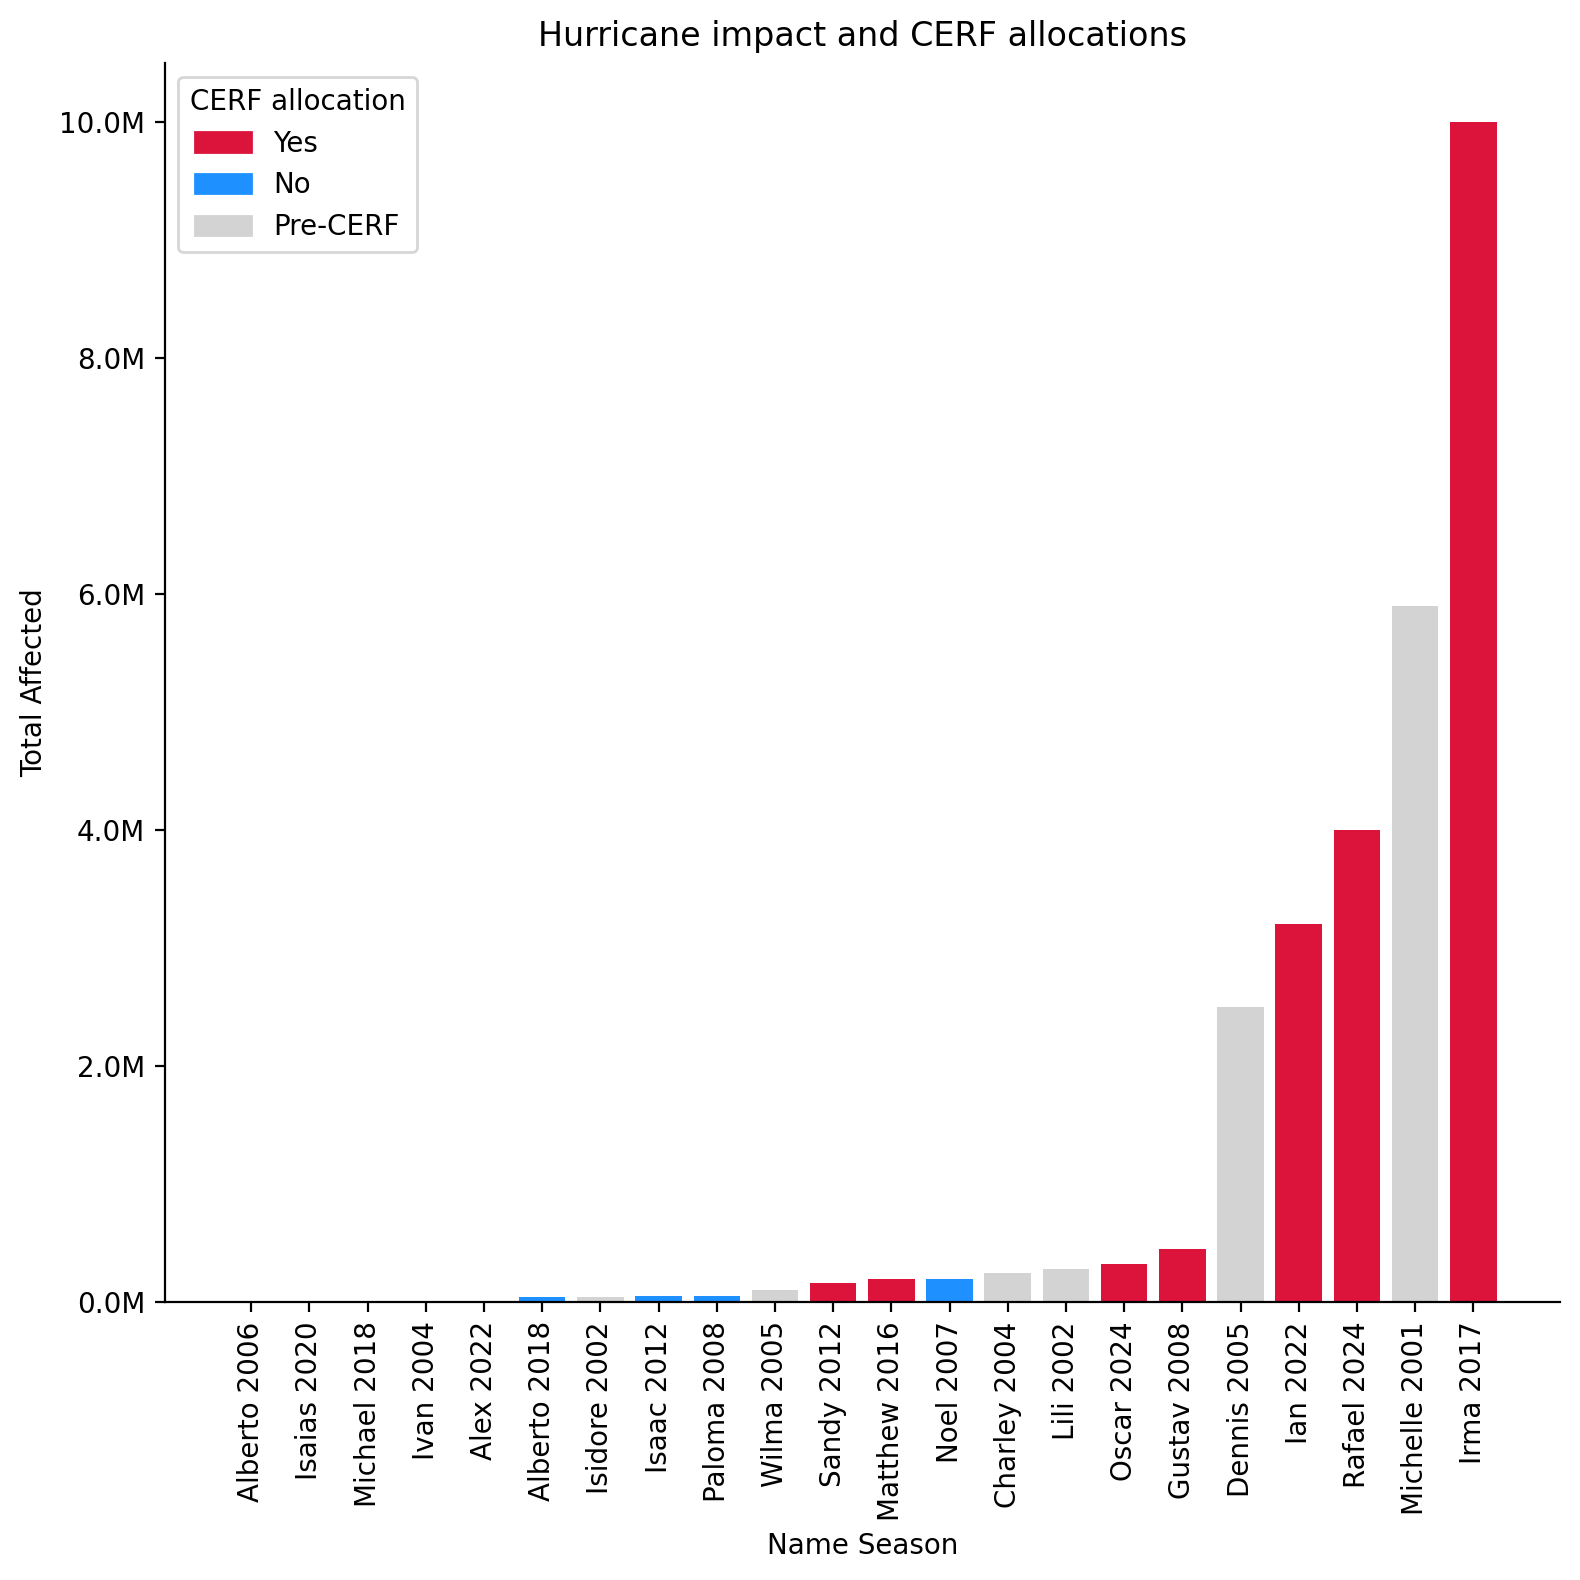

In [21]:
plot_impact("Total Affected")

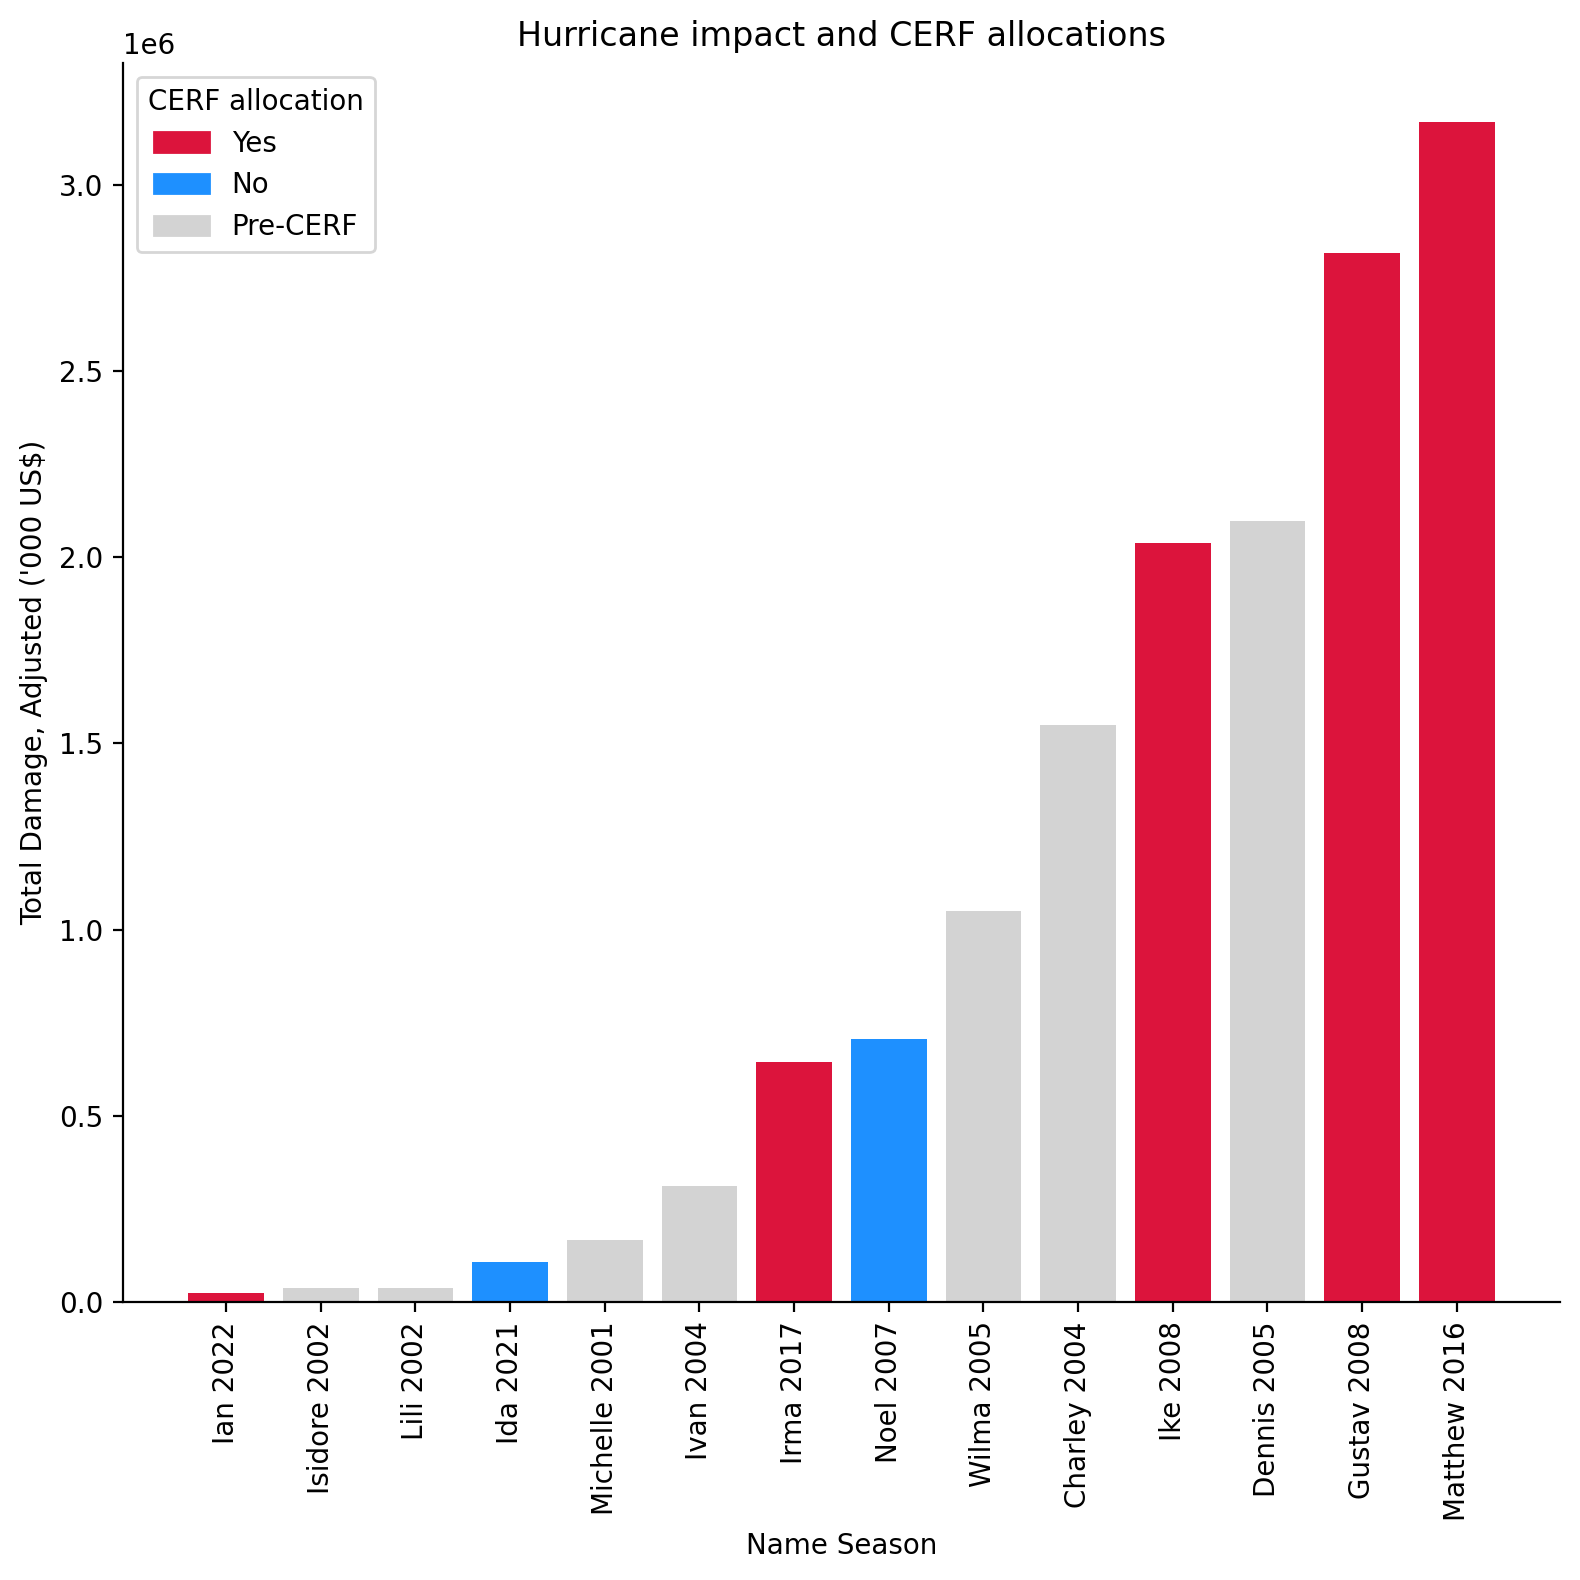

In [22]:
plot_impact("Total Damage, Adjusted ('000 US$)")

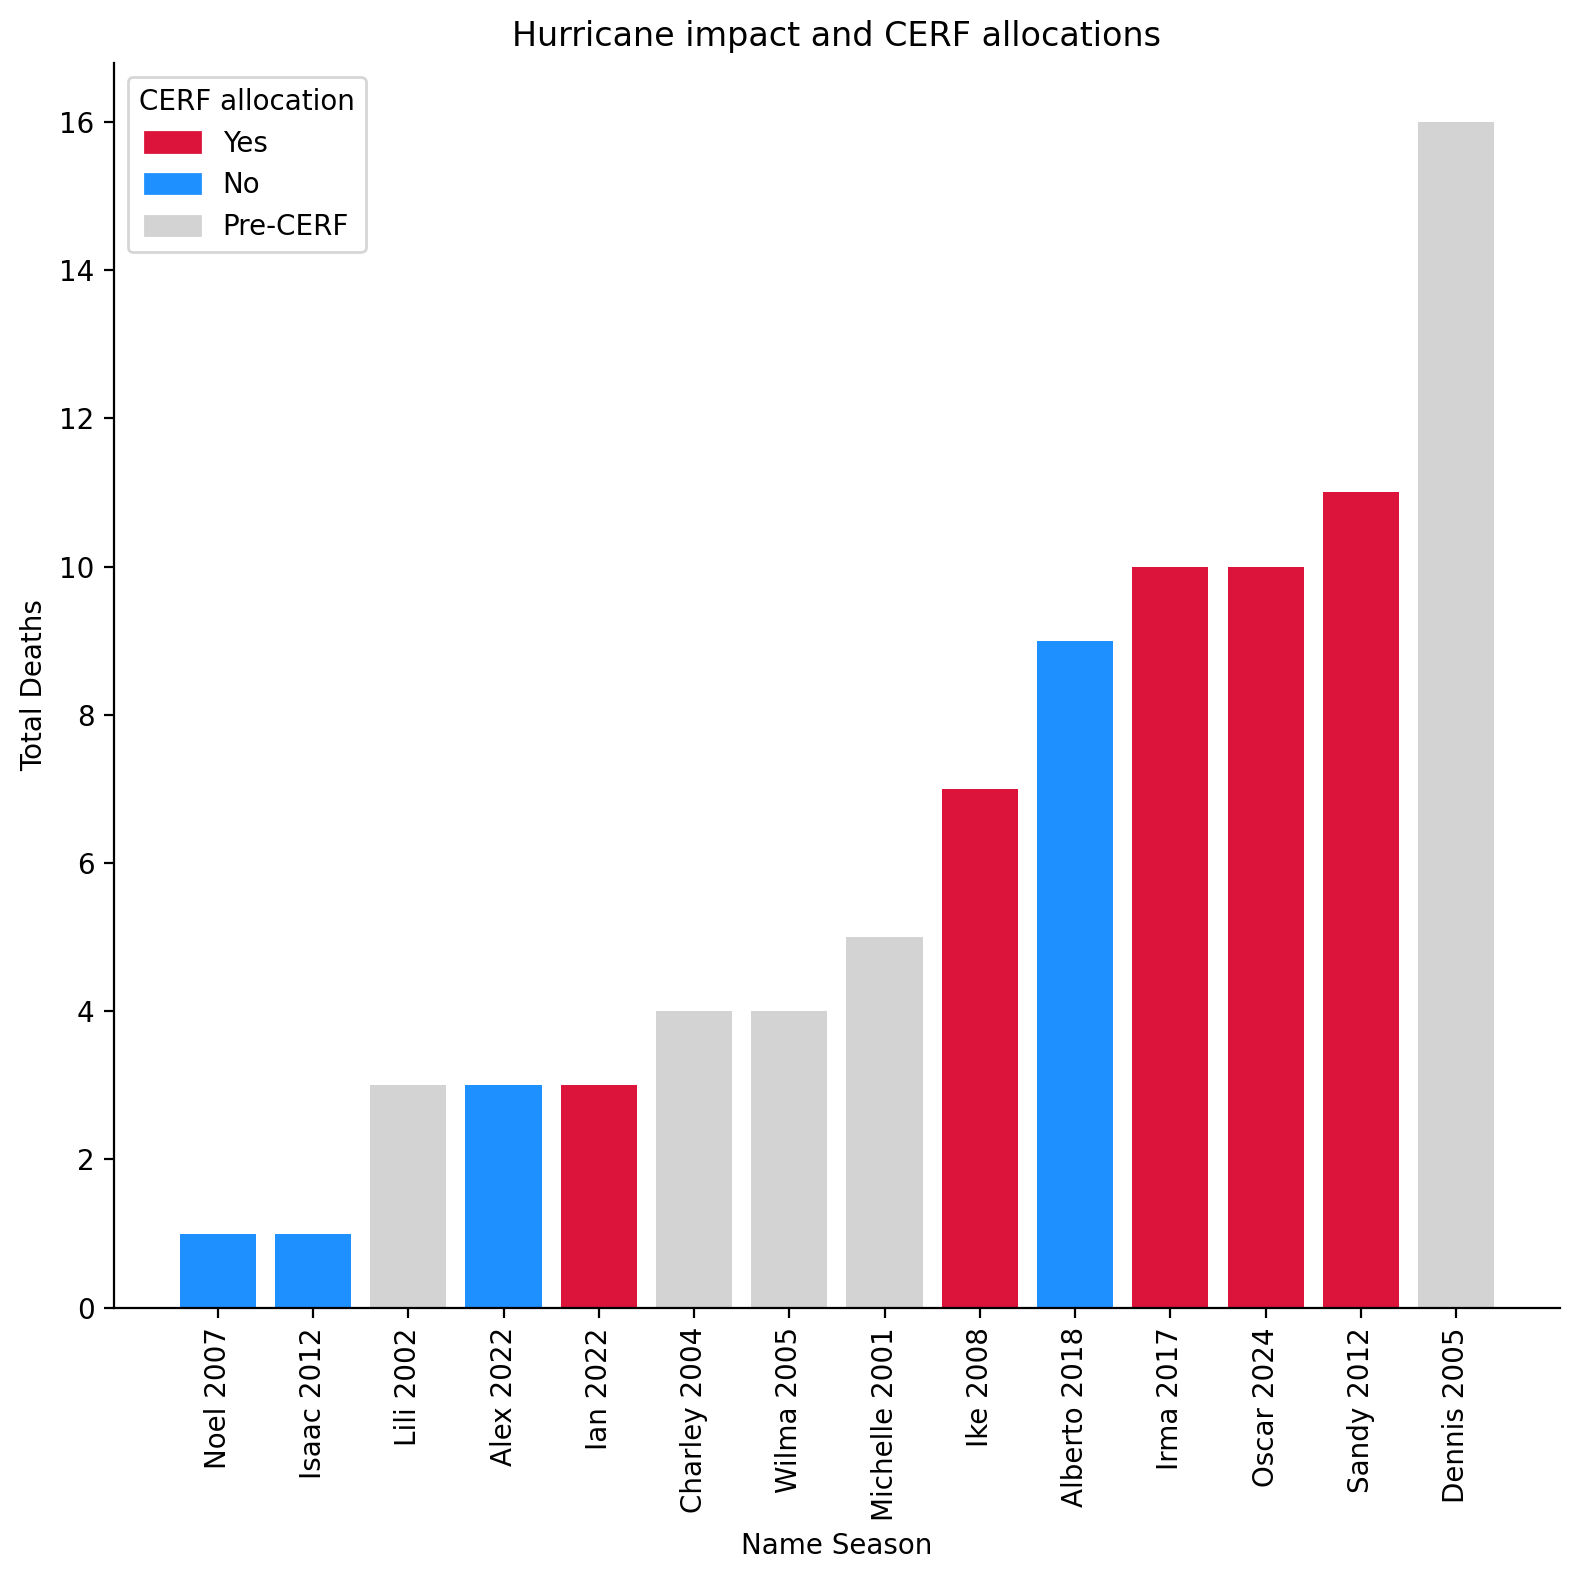

In [23]:
plot_impact("Total Deaths")

In [26]:
cerf_year_count = df_stats[df_stats["cerf"] == True]["season"].nunique()

In [46]:
cerf_year_count

6

In [27]:
cerf_total_years = 2024 - 2006 + 1

In [28]:
cerf_rp = (cerf_total_years + 1) / cerf_year_count

In [29]:
cerf_rp

3.3333333333333335

In [30]:
df_stats["Amount in US$"].mean()

np.float64(5446208.125)

In [31]:
df_stats

,sid,valid_time_min,valid_time_max,wind_speed_max,wind_speed_max_landfall,q50_total,q50_total_mean_abv,q50_roll2,q50_roll2_mean_abv,q50_roll3,...,Total Affected,Total Deaths,"Total Damage, Adjusted ('000 US$)",Amount in US$,season,name,name_season,cerf_str,target,target_with_cerf
0,2000233N12316,2000-08-24 00:00:00.000040,2000-08-24 12:00:00.000040,40.0,NaN,18.190000,35.262634,18.152500,34.911701,18.189999,...,0,0,0,NaN,2000,DEBBY,Debby 2000,nan,False,False
1,2000260N15308,2000-09-19 12:00:00.000040,2000-09-20 18:00:00.000040,30.0,NaN,26.412498,68.799995,21.250000,62.718685,23.750000,...,0,0,0,NaN,2000,HELENE,Helene 2000,nan,False,False
2,2001303N13276,2001-11-04 06:00:00.000040,2001-11-05 06:00:00.000040,120.0,115.0,94.369999,214.020828,76.807495,195.712280,94.297501,...,5900012,5,165279,NaN,2001,MICHELLE,Michelle 2001,nan,True,True
3,2002258N10300,2002-09-19 18:00:00.000040,2002-09-21 18:00:00.000040,110.0,75.0,78.592495,207.540146,40.644997,143.821213,56.139999,...,42500,0,37421,NaN,2002,ISIDORE,Isidore 2002,nan,False,False
4,2002265N10315,2002-09-29 00:00:00.000040,2002-10-02 00:00:00.000040,90.0,90.0,54.195000,89.869759,37.119995,67.565186,43.507500,...,281470,3,37421,NaN,2002,LILI,Lili 2002,nan,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,2023321N15278,2023-11-18 00:00:00.000039,2023-11-18 00:00:00.000039,30.0,NaN,3.947500,38.300976,3.947500,38.281227,3.947500,...,0,0,0,NaN,2023,UNNAMED,Unnamed 2023,False,False,False
58,2024216N20284,2024-08-02 12:00:00.000039,2024-08-04 00:00:00.000039,35.0,30.0,54.164997,103.377747,40.412502,75.217384,49.295002,...,0,0,0,NaN,2024,DEBBY,Debby 2024,False,False,False
59,2024268N17278,2024-09-25 12:00:00.000039,2024-09-25 12:00:00.000039,65.0,NaN,25.417499,116.488297,21.440001,99.156189,25.417500,...,0,0,0,NaN,2024,HELENE,Helene 2024,False,False,False
60,2024293N21294,2024-10-20 06:00:00.000039,2024-10-22 06:00:00.000039,75.0,75.0,12.205000,61.957958,9.135000,50.185165,12.029999,...,320000,10,0,3499569.0,2024,OSCAR,Oscar 2024,True,True,True


In [32]:
df_stats.columns

Index(['sid', 'valid_time_min', 'valid_time_max', 'wind_speed_max',
       'wind_speed_max_landfall', 'q50_total', 'q50_total_mean_abv',
       'q50_roll2', 'q50_roll2_mean_abv', 'q50_roll3', 'q50_roll3_mean_abv',
       'q80_total', 'q80_total_mean_abv', 'q80_roll2', 'q80_roll2_mean_abv',
       'q80_roll3', 'q80_roll3_mean_abv', 'q90_total', 'q90_total_mean_abv',
       'q90_roll2', 'q90_roll2_mean_abv', 'q90_roll3', 'q90_roll3_mean_abv',
       'q95_total', 'q95_total_mean_abv', 'q95_roll2', 'q95_roll2_mean_abv',
       'q95_roll3', 'q95_roll3_mean_abv', 'q99_total', 'q99_total_mean_abv',
       'q99_roll2', 'q99_roll2_mean_abv', 'q99_roll3', 'q99_roll3_mean_abv',
       'cerf', 'Total Affected', 'Total Deaths',
       'Total Damage, Adjusted ('000 US$)', 'Amount in US$', 'season', 'name',
       'name_season', 'cerf_str', 'target', 'target_with_cerf'],
      dtype='object')

In [43]:
blob_name = (
    f"{PROJECT_PREFIX}/processed/storm_stats/stats_with_targets2.parquet"
)
stratus.upload_parquet_to_blob(df_stats, blob_name)
df_stats

,sid,valid_time_min,valid_time_max,wind_speed_max,wind_speed_max_landfall,q50_total,q50_total_mean_abv,q50_roll2,q50_roll2_mean_abv,q50_roll3,...,Total Affected,Total Deaths,"Total Damage, Adjusted ('000 US$)",Amount in US$,season,name,name_season,cerf_str,target,target_with_cerf
0,2000233N12316,2000-08-24 00:00:00.000040,2000-08-24 12:00:00.000040,40.0,NaN,18.190000,35.262634,18.152500,34.911701,18.189999,...,0,0,0,NaN,2000,DEBBY,Debby 2000,nan,False,False
1,2000260N15308,2000-09-19 12:00:00.000040,2000-09-20 18:00:00.000040,30.0,NaN,26.412498,68.799995,21.250000,62.718685,23.750000,...,0,0,0,NaN,2000,HELENE,Helene 2000,nan,False,False
2,2001303N13276,2001-11-04 06:00:00.000040,2001-11-05 06:00:00.000040,120.0,115.0,94.369999,214.020828,76.807495,195.712280,94.297501,...,5900012,5,165279,NaN,2001,MICHELLE,Michelle 2001,nan,True,True
3,2002258N10300,2002-09-19 18:00:00.000040,2002-09-21 18:00:00.000040,110.0,75.0,78.592495,207.540146,40.644997,143.821213,56.139999,...,42500,0,37421,NaN,2002,ISIDORE,Isidore 2002,nan,False,False
4,2002265N10315,2002-09-29 00:00:00.000040,2002-10-02 00:00:00.000040,90.0,90.0,54.195000,89.869759,37.119995,67.565186,43.507500,...,281470,3,37421,NaN,2002,LILI,Lili 2002,nan,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,2023321N15278,2023-11-18 00:00:00.000039,2023-11-18 00:00:00.000039,30.0,NaN,3.947500,38.300976,3.947500,38.281227,3.947500,...,0,0,0,NaN,2023,UNNAMED,Unnamed 2023,False,False,False
58,2024216N20284,2024-08-02 12:00:00.000039,2024-08-04 00:00:00.000039,35.0,30.0,54.164997,103.377747,40.412502,75.217384,49.295002,...,0,0,0,NaN,2024,DEBBY,Debby 2024,False,False,False
59,2024268N17278,2024-09-25 12:00:00.000039,2024-09-25 12:00:00.000039,65.0,NaN,25.417499,116.488297,21.440001,99.156189,25.417500,...,0,0,0,NaN,2024,HELENE,Helene 2024,False,False,False
60,2024293N21294,2024-10-20 06:00:00.000039,2024-10-22 06:00:00.000039,75.0,75.0,12.205000,61.957958,9.135000,50.185165,12.029999,...,320000,10,0,3499569.0,2024,OSCAR,Oscar 2024,True,True,True


In [33]:
dicts = []
for rain_col in tqdm([x for x in df_stats.columns if x.startswith("q")]):
    for rain_thresh in df_stats[rain_col].unique():
        for wind_speed_max in df_stats["wind_speed_max"].unique():
            for wind_speed_max_landfall in df_stats[
                "wind_speed_max_landfall"
            ].unique():
                dff = df_stats[
                    (df_stats[rain_col] >= rain_thresh)
                    & (
                        (df_stats["wind_speed_max"] >= wind_speed_max)
                        | (
                            df_stats["wind_speed_max_landfall"]
                            >= wind_speed_max_landfall
                        )
                    )
                ]
                n_years_triggered = dff["season"].nunique()
                n_storms_triggered = dff["sid"].nunique()
                dicts.append(
                    {
                        "rain_col": rain_col,
                        "rain_thresh": rain_thresh,
                        "wind_speed_max": wind_speed_max,
                        "wind_speed_max_landfall": wind_speed_max_landfall,
                        "target_sum": dff["target"].sum(),
                        "impact_sum": dff["Total Affected"].sum(),
                        "target_with_cerf_sum": dff["target_with_cerf"].sum(),
                        "cerf_sum": dff["cerf"].sum(),
                        "n_years": n_years_triggered,
                        "n_storms": n_storms_triggered,
                    }
                )

  0%|          | 0/30 [00:00<?, ?it/s]

In [34]:
df_results = pd.DataFrame(dicts)

In [35]:
df_results

,rain_col,rain_thresh,wind_speed_max,wind_speed_max_landfall,target_sum,impact_sum,target_with_cerf_sum,cerf_sum,n_years,n_storms
0,q50_total,18.190000,40.0,NaN,6,27069337,9,7,18,31
1,q50_total,18.190000,40.0,115.0,6,27069337,9,7,18,31
2,q50_total,18.190000,40.0,75.0,6,27069337,9,7,18,31
3,q50_total,18.190000,40.0,90.0,6,27069337,9,7,18,31
4,q50_total,18.190000,40.0,25.0,6,27069337,9,7,18,35
...,...,...,...,...,...,...,...,...,...,...
752233,q99_roll3_mean_abv,287.727478,65.0,100.0,5,23164562,8,6,12,15
752234,q99_roll3_mean_abv,287.727478,65.0,130.0,5,23164562,8,6,12,15
752235,q99_roll3_mean_abv,287.727478,65.0,30.0,5,23210058,8,6,13,18
752236,q99_roll3_mean_abv,287.727478,65.0,70.0,5,23164562,8,6,12,15


In [37]:
def get_rain_params(rain_col):
    agg_type = "mean_abv" if rain_col.endswith("mean_abv") else "quantile"
    q = int(rain_col[1:3])
    window = rain_col.split("_")[1]
    return agg_type, q, window


df_results[["rain_agg", "rain_q", "rain_window"]] = (
    df_results["rain_col"].apply(get_rain_params).apply(pd.Series)
)

In [38]:
df_results

,rain_col,rain_thresh,wind_speed_max,wind_speed_max_landfall,target_sum,impact_sum,target_with_cerf_sum,cerf_sum,n_years,n_storms,rain_agg,rain_q,rain_window
0,q50_total,18.190000,40.0,NaN,6,27069337,9,7,18,31,quantile,50,total
1,q50_total,18.190000,40.0,115.0,6,27069337,9,7,18,31,quantile,50,total
2,q50_total,18.190000,40.0,75.0,6,27069337,9,7,18,31,quantile,50,total
3,q50_total,18.190000,40.0,90.0,6,27069337,9,7,18,31,quantile,50,total
4,q50_total,18.190000,40.0,25.0,6,27069337,9,7,18,35,quantile,50,total
...,...,...,...,...,...,...,...,...,...,...,...,...,...
752233,q99_roll3_mean_abv,287.727478,65.0,100.0,5,23164562,8,6,12,15,mean_abv,99,roll3
752234,q99_roll3_mean_abv,287.727478,65.0,130.0,5,23164562,8,6,12,15,mean_abv,99,roll3
752235,q99_roll3_mean_abv,287.727478,65.0,30.0,5,23210058,8,6,13,18,mean_abv,99,roll3
752236,q99_roll3_mean_abv,287.727478,65.0,70.0,5,23164562,8,6,12,15,mean_abv,99,roll3


In [39]:
df_results["cerf_sum"] = df_results["cerf_sum"].astype(int)

In [40]:
blob_name = f"{PROJECT_PREFIX}/processed/trigger_metrics_ibtracs_imerg.parquet"
stratus.upload_parquet_to_blob(df_results, blob_name)

(70.0, 150.0)

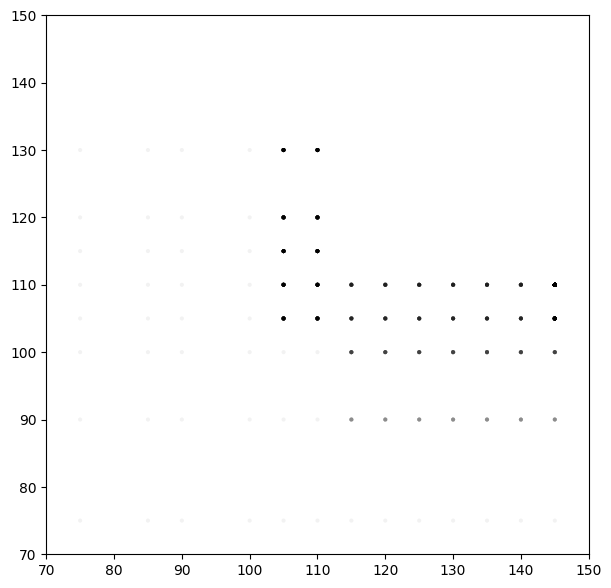

In [436]:
fig, ax = plt.subplots(figsize=(7, 7))

# df_plot = df_results[df_results["cerf_sum"] == 3]
df_plot = df_results[df_results["target_sum"] == 5]

ax.scatter(
    df_plot["wind_speed_max"],
    df_plot["wind_speed_max_landfall"],
    color="k",
    edgecolors="none",
    alpha=0.05,
    marker=".",
)
ax.set_xlim(70, 150)
ax.set_ylim(70, 150)

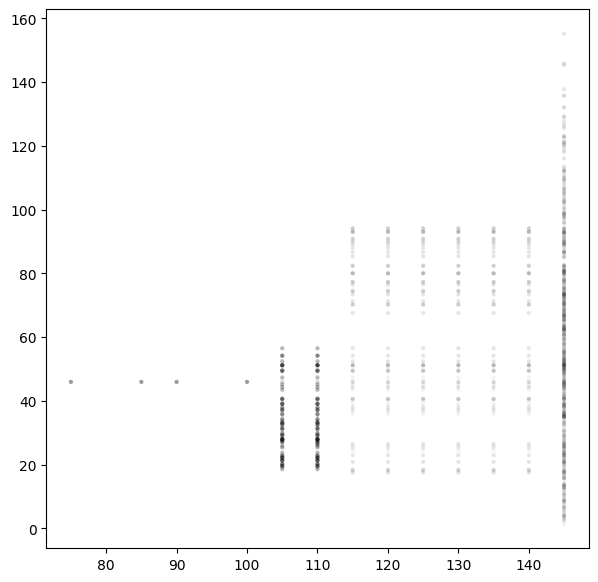

In [437]:
fig, ax = plt.subplots(figsize=(7, 7))

# df_plot = df_results[df_results["cerf_sum"] == 3]

ax.scatter(
    df_plot["wind_speed_max"],
    df_plot["rain_thresh"],
    color="k",
    edgecolors="none",
    alpha=0.05,
    marker=".",
)
# ax.set_xlim(70, 150)
# ax.set_ylim(70, 150)

In [438]:
df_results.max()

rain_col                   q99_total_mean_abv
rain_thresh                        531.149475
wind_speed_max                          145.0
wind_speed_max_landfall                 130.0
target_sum                                  5
impact_sum                           22612062
target_with_cerf_sum                        6
cerf_sum                                    3
rain_agg                             quantile
rain_q                                     99
rain_window                             total
dtype: object

<Axes: xlabel='target_with_cerf_sum'>

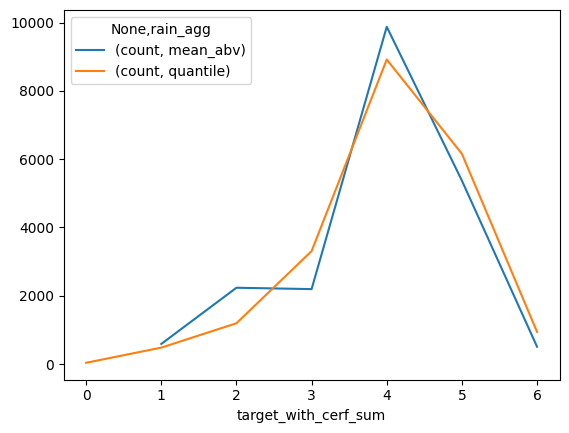

In [467]:
df_results.groupby(["rain_agg", "target_with_cerf_sum"]).size().rename(
    "count"
).reset_index().pivot(columns="rain_agg", index="target_with_cerf_sum").plot()

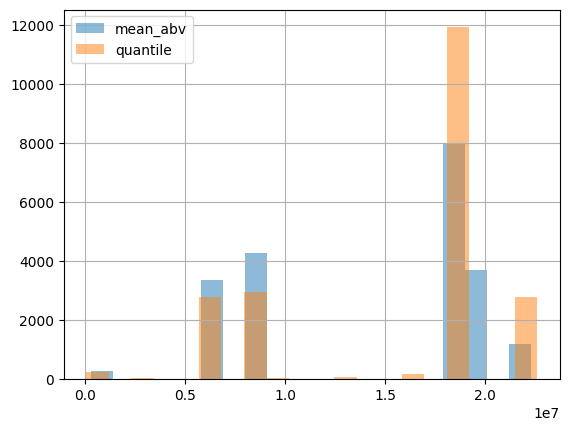

In [440]:
fig, ax = plt.subplots()

for window, group in df_results.groupby("rain_agg"):
    group["impact_sum"].hist(ax=ax, alpha=0.5, label=window, bins=20)

ax.legend()

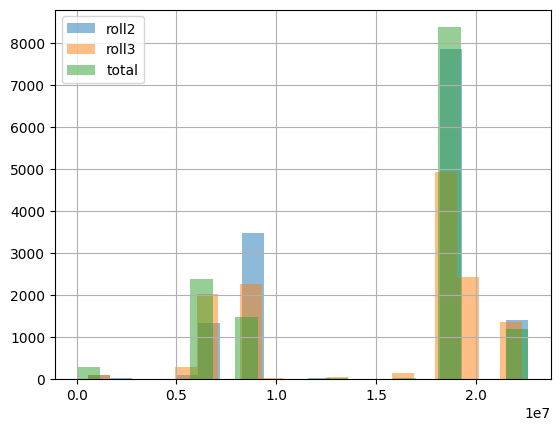

In [441]:
fig, ax = plt.subplots()

for window, group in df_results.groupby("rain_window"):
    group["impact_sum"].hist(ax=ax, alpha=0.5, label=window, bins=20)

ax.legend()

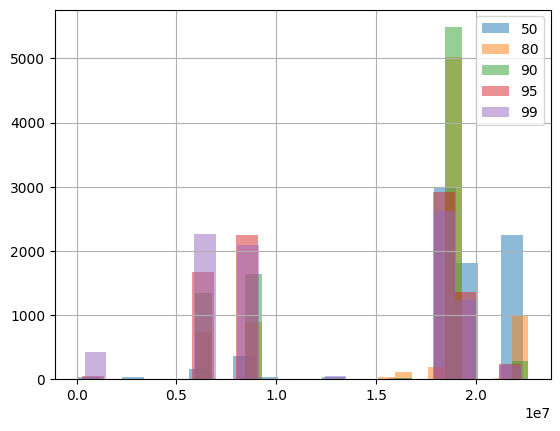

In [442]:
fig, ax = plt.subplots()

for q, group in df_results.groupby("rain_q"):
    group["impact_sum"].hist(ax=ax, alpha=0.5, label=q, bins=20)

ax.legend()

In [444]:
df_results.groupby("rain_q")[
    ["impact_sum", "cerf_sum", "target_sum", "target_with_cerf_sum"]
].mean()

,impact_sum,cerf_sum,target_sum,target_with_cerf_sum
rain_q,,,,
50,1.872799e+07,1.922340,3.592804,4.300932
80,1.683187e+07,1.891519,3.074032,4.042716
90,1.506497e+07,1.816492,2.727190,3.851391
95,1.365807e+07,1.897151,2.639792,3.862868
99,1.252712e+07,2.029757,2.771867,3.832958


In [445]:
df_results.groupby("rain_window")[
    ["impact_sum", "cerf_sum", "target_sum", "target_with_cerf_sum"]
].mean()

,impact_sum,cerf_sum,target_sum,target_with_cerf_sum
rain_window,,,,
roll2,1.523610e+07,1.944015,2.973957,4.049579
roll3,1.511703e+07,1.928006,2.920097,3.959279
total,1.541445e+07,1.862684,2.940042,3.895962


In [474]:
df_results.sort_values(["cerf_sum", "impact_sum"], ascending=False).iloc[:20]

,rain_col,rain_thresh,wind_speed_max,wind_speed_max_landfall,target_sum,impact_sum,target_with_cerf_sum,cerf_sum,rain_agg,rain_q,rain_window
11753,q80_roll2,98.341003,120.0,75.0,4,22612062,5,3,quantile,80,roll2
11754,q80_roll2,98.341003,120.0,90.0,4,22612062,5,3,quantile,80,roll2
11755,q80_roll2,98.341003,120.0,100.0,4,22612062,5,3,quantile,80,roll2
11756,q80_roll2,98.341003,110.0,75.0,4,22612062,5,3,quantile,80,roll2
11757,q80_roll2,98.341003,110.0,90.0,4,22612062,5,3,quantile,80,roll2
11758,q80_roll2,98.341003,110.0,100.0,4,22612062,5,3,quantile,80,roll2
11759,q80_roll2,98.341003,90.0,NaN,4,22612062,5,3,quantile,80,roll2
11760,q80_roll2,98.341003,90.0,115.0,4,22612062,5,3,quantile,80,roll2
11761,q80_roll2,98.341003,90.0,75.0,4,22612062,5,3,quantile,80,roll2
11762,q80_roll2,98.341003,90.0,90.0,4,22612062,5,3,quantile,80,roll2


In [451]:
df_results.sort_values(
    ["target_with_cerf_sum", "impact_sum"], ascending=False
).iloc[:20]

,rain_col,rain_thresh,wind_speed_max,wind_speed_max_landfall,target_sum,impact_sum,target_with_cerf_sum,cerf_sum,rain_agg,rain_q,rain_window
380,q50_total,24.472499,120.0,110.0,5,22289476,6,3,quantile,50,total
384,q50_total,24.472499,115.0,110.0,5,22289476,6,3,quantile,50,total
385,q50_total,24.472499,125.0,110.0,5,22289476,6,3,quantile,50,total
764,q50_total,25.622500,120.0,110.0,5,22289476,6,3,quantile,50,total
768,q50_total,25.622500,115.0,110.0,5,22289476,6,3,quantile,50,total
769,q50_total,25.622500,125.0,110.0,5,22289476,6,3,quantile,50,total
771,q50_total,22.917500,120.0,110.0,5,22289476,6,3,quantile,50,total
775,q50_total,22.917500,115.0,110.0,5,22289476,6,3,quantile,50,total
776,q50_total,22.917500,125.0,110.0,5,22289476,6,3,quantile,50,total
810,q50_total,22.997499,120.0,110.0,5,22289476,6,3,quantile,50,total
